In [2]:
from google.colab import files
uploaded = files.upload()


Saving spam.csv to spam (1).csv


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



=== Logistic Regression (Improved) ===
Confusion Matrix:
[[953  12]
 [ 13 137]]

Accuracy: 0.9776
Precision: 0.9195
Recall: 0.9133
F1-Score: 0.9164

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.92      0.91      0.92       150

    accuracy                           0.98      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115

AUC Score: 0.9852


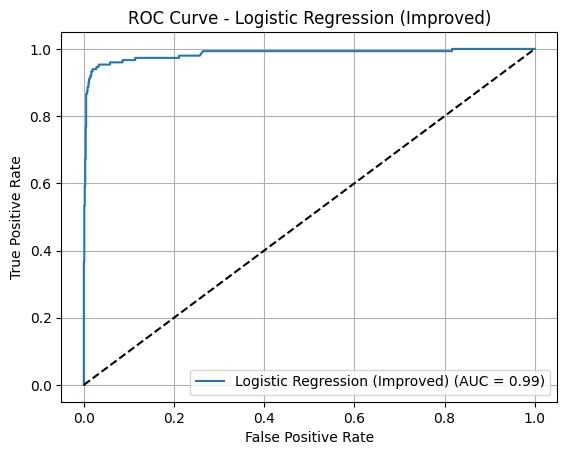

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from scipy.sparse import hstack, csr_matrix

nltk.download('stopwords')

# Load and preprocess data
def load_and_preprocess():
    df = pd.read_csv('spam.csv', encoding='latin-1')
    df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})

    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()

    def clean_text(text):
        text = re.sub(r'[^\w\s]', '', text.lower())
        words = [ps.stem(word) for word in text.split() if word not in stop_words]
        return ' '.join(words)

    df['clean_text'] = df['text'].apply(clean_text)
    df['label'] = df['label'].map({'ham': 0, 'spam': 1})
    return df

# Feature extraction
def extract_features(df):
    tfidf = TfidfVectorizer(max_features=3000)
    X_tfidf = tfidf.fit_transform(df['clean_text'])

    df['polarity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['subjectivity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    sentiment_features = csr_matrix(df[['polarity', 'subjectivity']].values)
    X_combined = hstack([X_tfidf, sentiment_features])
    return X_combined, df['label']

# Model evaluation
def evaluate_model(name, model, X_test, y_test, y_pred=None, y_prob=None):
    if y_pred is None:
        y_pred = model.predict(X_test)
    if y_prob is None:
        try:
            y_prob = model.predict_proba(X_test)[:, 1]
        except:
            y_prob = y_pred

    print(f"\n=== {name} ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"\nAccuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f"AUC Score: {roc_auc:.4f}")

    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Main
if __name__ == "__main__":
    df = load_and_preprocess()
    X, y = extract_features(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
    model.fit(X_train, y_train)
    evaluate_model("Logistic Regression (Improved)", model, X_test, y_test)


In [4]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(name, model, X_test, y_test, y_pred=None, y_prob=None):
    if y_pred is None:
        y_pred = model.predict(X_test)
    if y_prob is None:
        try:
            y_prob = model.predict_proba(X_test)[:, 1]
        except:
            y_prob = y_pred  # fallback if no probability output

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n=== {name} ===")
    print("Confusion Matrix:")
    print(cm)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"\nAccuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f"AUC Score: {roc_auc:.4f}")

    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



=== Logistic Regression ===
Confusion Matrix:
[[961   4]
 [ 48 102]]

Accuracy: 0.9534
Precision: 0.9623
Recall: 0.6800
F1-Score: 0.7969

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.96      0.68      0.80       150

    accuracy                           0.95      1115
   macro avg       0.96      0.84      0.89      1115
weighted avg       0.95      0.95      0.95      1115

AUC Score: 0.9852


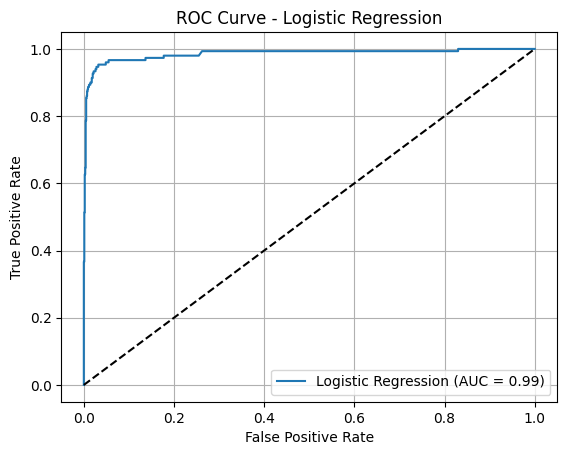

In [5]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

evaluate_model("Logistic Regression", model, X_test, y_test, y_pred, y_prob)
